In [1]:
import os
os.environ["KERAS_BACKEND"] = "cntk"

In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime,timedelta
import  math
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Veriyi Yükleme

In [3]:
df = pd.read_csv('demo.csv',encoding='utf8')

In [7]:
df.head()

,Payment_Date,Payment_Total
0,2018-01-01 00:00:00,4530.655276
1,2018-01-01 01:00:00,4158.526500
2,2018-01-01 02:00:00,1174.322270
3,2018-01-01 03:00:00,1431.577385
4,2018-01-01 04:00:00,1030.975000


In [6]:
df.Payment_Total.describe()

count     6486.000000
mean      7486.894764
std       6024.058052
min          0.000000
25%       2215.052346
50%       7006.007000
75%      10931.131397
max      82419.133547
Name: Payment_Total, dtype: float64

# Veriyi Düzenleme

In [5]:
def circular_norm(val,max_val):
    val = val*2*math.pi/max_val
    return np.array([math.cos(val),math.sin(val)])   #circular normalization, nedir neden lazım?

def get_date_vec(dstr):
    t,s = dstr.split(' ')
    day = int(t.split('-')[2])
    month = int(t.split('-')[1])
    year = int(t.split('-')[0])
    hour = int(s.split(':')[0])
    dt = datetime(year, month, day, hour)
    wday  = dt.weekday()
    wdvec = circular_norm(wday,7)
    dvec = circular_norm(day,31)
    mvec =  circular_norm(month,12)
    hvec = circular_norm(hour,24)
    date_vec = np.concatenate([wdvec,dvec,mvec,hvec])
    return np.float32(date_vec)

In [13]:
date_vecs = []
for pd in df.Payment_Date:
    date_vecs.append(get_date_vec(pd)) 
date_vecs = np.array(date_vecs)   
#her bir zaman (haftanın gunu ayın gun ay günün saati - [wdvec,dvec,mvec,hvec]) icin vector hesaplanıyor

In [9]:
#model 24 saat saatin satış değerlerini alıp 25.saati tahmin ediyor

X = df.Payment_Total.values
ts_data = []  #timestep data
out_data = [] #çıkış: 25. saat satış tutarı
day_max = [] # her 24giriş bloğu için maksimum değerleri
delay = 24 #input uzunluğu
for i in range(0,len(df)-delay): 
    invec = X[i:i+delay]
    dmax = invec.max()
    
    #günün maks degeriyle norm.
    
    if dmax == 0 :
        dmax =1
    day_max.append(dmax)
    ts_data.append(invec/dmax) 
    out_data.append(X[i+delay]/dmax) #25. değer
ts_data = np.array(ts_data)
out_data = np.array(out_data)

In [10]:
ts_data = np.expand_dims(np.array(ts_data),-1) 

# lstm girişinde kullanılabilmesi için 6462 adet 24 time stepte 1 uzunlukta değer gerekiyor.

In [11]:
ts_data.shape,out_data.shape  #Expand dimm sonrası

((6462L, 24L, 1L), (6462L,))

In [12]:
split = 4000
X1_train = ts_data[:split,:,:]   #egitim verisi olarak 4000 kayıt alınıyor
X1_valid = ts_data[split:,:,:]
Y_train = out_data[:split]
Y_valid = out_data[split:]
day_max_train = day_max[:split]
day_max_valid = day_max[split:]

In [14]:
X2_train = date_vecs[delay:split+delay] 
X2_valid = date_vecs[split+delay:]

# Model Tanımı Ve Eğitimi

In [15]:
from keras.models import Model
from keras.layers import Dense, Activation,LSTM, GRU,Dropout,concatenate,Input
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

Using CNTK backend


In [25]:
core_dim = 64
dratio = 0.25
#lstm
x1 = Input(shape=ts_data.shape[1:]) #zaman serisi girişi
sub1 = LSTM(core_dim)(x1)  
sub1 = Dropout(dratio)(sub1)
#dense fixed
x2 = Input(shape=date_vecs.shape[1:])   # tahmin edilecek zamanın vektörü
sub2 = Dense(2*core_dim,activation='relu')(x2)
sub2 = Dropout(dratio)(sub2)
sub2 = Dense(core_dim,activation='relu')(sub2)

#neden sadece lstm ile tahmin yapılmadı? Tarihin de tahmini etkileyen bir öznitelik olmasından dolayı ayrı bir giriş olarak 
#alındı.

# merging
out = concatenate([sub1,sub2])
out = Dropout(dratio)(out)
out = Dense(core_dim,activation='relu')(out)
out = Dropout(dratio)(out)
out = Dense(1)(out)
model = Model(inputs=[x1, x2], outputs=out)
model.compile(loss='mse', optimizer='rmsprop')

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 8L)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 24L, 1L)      0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          1152        input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           16896       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_6 

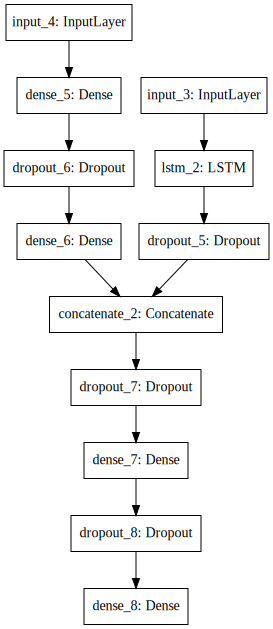

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot',format='svg'))

In [27]:
model_checkpoint = ModelCheckpoint('best_comp.h5', monitor='val_loss', save_best_only=True,verbose=1)
redu = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='min', min_lr=0.00001)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=17, verbose=1, mode='min')
cbacks = [model_checkpoint,early,redu]

In [28]:
hs = model.fit([X1_train,X2_train], Y_train, batch_size=64, 
               epochs=150,validation_data=([X1_valid,X2_valid],Y_valid),callbacks=cbacks) 

Train on 4000 samples, validate on 2462 samples
Epoch 1/150
 192/4000 [>.............................] - ETA: 3s - loss: 0.3228

C:\Anaconda2\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input4055") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
C:\Anaconda2\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input4621") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


4000/4000 [==============================] - 2s 591us/step - loss: 0.0701 - val_loss: 0.0284

Epoch 00001: val_loss improved from inf to 0.02839, saving model to best_comp.h5
Epoch 2/150
4000/4000 [==============================] - 2s 568us/step - loss: 0.0321 - val_loss: 0.0249

Epoch 00002: val_loss improved from 0.02839 to 0.02485, saving model to best_comp.h5
Epoch 3/150
4000/4000 [==============================] - 2s 572us/step - loss: 0.0256 - val_loss: 0.0207

Epoch 00003: val_loss improved from 0.02485 to 0.02071, saving model to best_comp.h5
Epoch 4/150
4000/4000 [==============================] - 2s 537us/step - loss: 0.0221 - val_loss: 0.0202

Epoch 00004: val_loss improved from 0.02071 to 0.02025, saving model to best_comp.h5
Epoch 5/150
4000/4000 [==============================] - 2s 553us/step - loss: 0.0191 - val_loss: 0.0227

Epoch 00005: val_loss did not improve from 0.02025
Epoch 6/150
4000/4000 [==============================] - 2s 537us/step - loss: 0.0179 - val_los

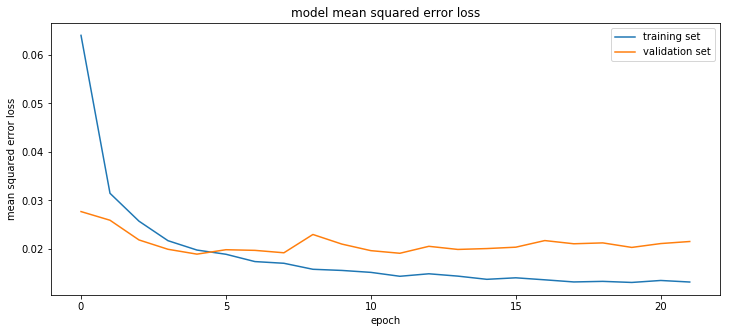

In [19]:
# loss plot
plt.figure(figsize=(12,5))
plt.plot(hs.history['loss'])
plt.plot(hs.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [20]:
model.load_weights('best_comp.h5')

In [23]:
preds = model.predict([X1_valid,X2_valid])
preds = preds[:,0]

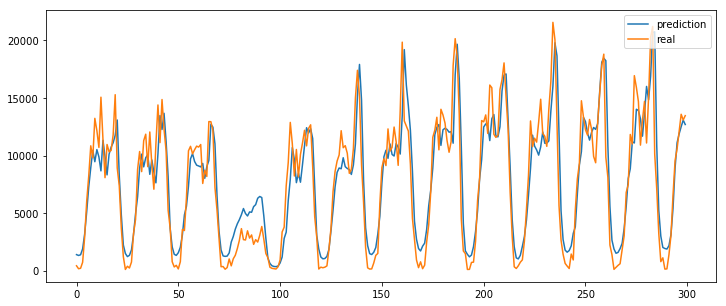

In [24]:
beg = 900
end = 1200
plt.figure(figsize=(12,5))
plt.plot(preds[beg:end]*day_max_valid[beg:end])
plt.plot(Y_valid[beg:end]*day_max_valid[beg:end])
plt.legend(['prediction', 'real'], loc='upper right')